<a href="https://colab.research.google.com/github/kittikhun62/efficientnet_keras_transfer_learning/blob/master/UNfreeze2Class_datanew_nsc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import from drive

In [1]:
import pandas as pd
import shutil
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv (r'/content/drive/My Drive/data_nsc - ใช้อันนี้เทรนV2.csv')
df

,No,Name_file,Name_Paper,journal,path_Picture,detail,Class,BET,Size(mico)
0,1,1-s2.0-S2352152X22008957-main,Activated carbons obtained by environmentally ...,Journal of Energy Storage,/content/drive/My Drive/modelnsc/1-s2.0-S23521...,original,401-3200,923.0,10
1,2,1-s2.0-S2352152X22008957-main,Activated carbons obtained by environmentally ...,Journal of Energy Storage,/content/drive/My Drive/modelnsc/1-s2.0-S23521...,original,401-3200,1223.0,10
2,3,1-s2.0-S2352152X22008957-main,Activated carbons obtained by environmentally ...,Journal of Energy Storage,/content/drive/My Drive/modelnsc/1-s2.0-S23521...,original,401-3200,1056.0,10
3,4,1-s2.0-S2352152X22008957-main,Activated carbons obtained by environmentally ...,Journal of Energy Storage,/content/drive/My Drive/modelnsc/1-s2.0-S23521...,original,401-3200,856.0,10
4,5,1-s2.0-S2352152X22008957-main,Activated carbons obtained by environmentally ...,Journal of Energy Storage,/content/drive/My Drive/modelnsc/1-s2.0-S23521...,original,401-3200,1263.0,10
...,...,...,...,...,...,...,...,...,...
1321,1322,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/modelnsc/1-s2.0-S09266...,original,0-400,11.0,10
1322,1323,new-sb,Biosugarcane-based carbon support for high- pe...,iScience,/content/drive/My Drive/modelnsc/new-sb/18.png,original,0-400,53.7,10
1323,1324,new-sb,Biosugarcane-based carbon support for high- pe...,iScience,/content/drive/My Drive/modelnsc/new-sb/19.png,original,0-400,34.3,10
1324,1325,new-sb,Biosugarcane-based carbon support for high- pe...,iScience,/content/drive/My Drive/modelnsc/new-sb/20.png,original,0-400,27.2,10


# Imports library

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## hyper parameter


In [4]:
batch_size = 16

width = 150
height = 150

epochs = 1000 #จำนวนรอบในการ Train

NUM_TRAIN = 1289  # จำนวนภาพ Train
NUM_TEST = 17 #จำนวนภาพ Test

dropout_rate = 0.3
input_shape = (height, width, 3) #ขนาด image enter

## Clone efficientnet repo

In [5]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 4.85 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [6]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [7]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
#EfficientNet สร้างขึ้นสำหรับการจำแนกประเภท ImageNet ประกอบด้วยป้ายกำกับคลาส 1,000 รายการ เรามีเพียง 2 เลเยอร์เท่านั้น ซึ่งหมายความว่าเลเยอร์สองสามเลเยอร์สุดท้ายสำหรับการจำแนกไม่มีประโยชน์สำหรับเรา สามารถยกเว้นได้ขณะโหลดโมเดลโดยระบุอาร์กิวเมนต์ include_top เป็น False และนำไปใช้กับโมเดล ImageNet อื่นๆ ที่มีอยู่ในแอปพลิเคชัน Keras เช่นกัน

conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 1s 0us/step


In [8]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

In [9]:
import sys
sys.path.append('/content/drive/My Drive/new/nsc4.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [10]:
#load model 
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/new/nsc4.h5')
height = width = model.input_shape[1]

In [11]:
base_dir = '/content/drive/My Drive/modeldatansc'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [12]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, # image input 0-255 --> 0-1 เปลี่ยนค่าสี
      rotation_range=40,# หมุนภาพในองศา
      width_shift_range=0.2, #เปลี่ยนความกว้าง
      height_shift_range=0.2, #ปลี่ยนความสูง
      shear_range=0.2, #ทำให้ภาพเบี้ยว
      zoom_range=0.2, # Randomly zoom image
      horizontal_flip=True, 
      #โดย Default เมื่อมีการเลื่อนภาพ บิดภาพ หมุนภาพ จะเกิดพื้นที่ว่างที่มุม 
      #ซึ่งจะมีการเติมภาพให้เต็มโดยใช้เทคนิคแบบ Nearest neighbor ซึ่งเป็นการดึงสีบริเวณใหล้าเคียงมาระบายให้เต็ม แต่เราก็ยังสามารถกำหนดวิธีการ Fill ภาพด้วยเทคนิคอื่นได้จาก Parameter fill_mode
      fill_mode='nearest')
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')
     



Found 1279 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


In [13]:
# multiply_16
# set 'multiply_16' and following layers trainable
model.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False  
     

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [15]:

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-15-caa7b37242a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/1000
80/80 [==============================] - 84s 863ms/step - loss: 0.5380 - acc: 0.7303 - val_loss: 0.5659 - val_acc: 0.6875
Epoch 2/1000
80/80 [==============================] - 6s 65ms/step - loss: 0.5352 - acc: 0.7389 - val_loss: 0.5303 - val_acc: 0.7500
Epoch 3/1000
80/80 [==============================] - 6s 68ms/step - loss: 0.5197 - acc: 0.7475 - val_loss: 0.5091 - val_acc: 0.6875
Epoch 4/1000
80/80 [==============================] - 6s 65ms/step - loss: 0.5259 - acc: 0.7435 - val_loss: 0.5388 - val_acc: 0.7500
Epoch 5/1000
80/80 [==============================] - 6s 65ms/step - loss: 0.5230 - acc: 0.7334 - val_loss: 0.5246 - val_acc: 0.7500
Epoch 6/1000
80/80 [==============================] - 6s 64ms/step - loss: 0.5337 - acc: 0.7443 - val_loss: 0.5221 - val_acc: 0.7500
Epoch 7/1000
80/80 [==============================] - 6s 68ms/step - loss: 0.5404 - acc: 0.7334 - val_loss: 0.5483 - val_acc: 0.6875
Epoch 8/1000
80/80 [==============================] - 6s 68ms/step 

## Plot training performance

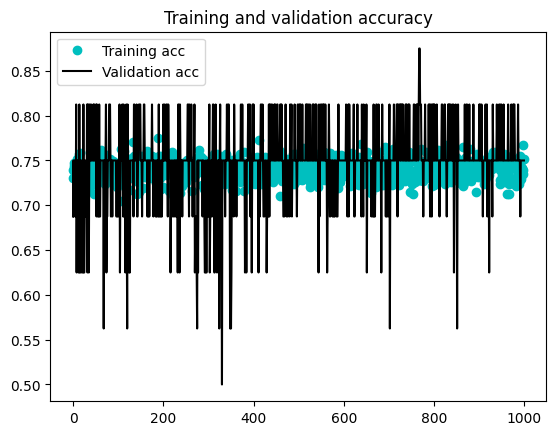

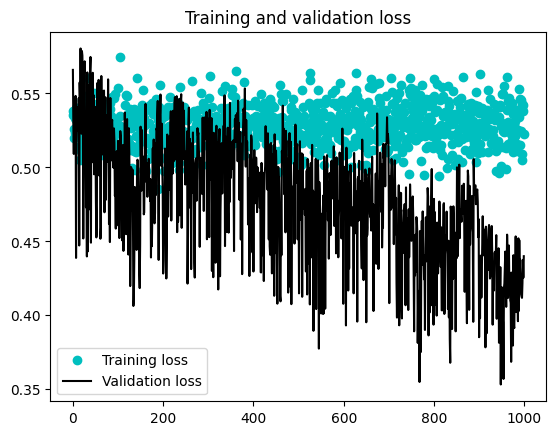

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'co', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
     

### SAVE model

In [17]:
os.makedirs('./content/drive/My Drive/new', exist_ok=True)
model.save('./content/drive/My Drive/new/nsc5.h5')

In [18]:
from google.colab import files

In [19]:
files.download("./content/drive/My Drive/new/nsc5.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>